In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal

df = pd.read_csv(r"px_last.csv", index_col=0, parse_dates=True)
df = df[['SPY US Equity','DIA US Equity', 'QQQ US Equity']]

start_date_total_set = "2011-01-03"
end_date_total_set = "2015-04-13"

# Jours de bourse aux États-Unis (NYSE)
nyse = mcal.get_calendar("NYSE")

# Obtenir tous les jours d'ouverture du marché entre les deux dates
trading_days = nyse.schedule(start_date=start_date_total_set, end_date=end_date_total_set)
trading_days_index = trading_days.index

# df utilisé dans le papier
df_total_set_prix = df.loc[df.index.intersection(trading_days_index)]

# df daily returns
df_total_set_daily = np.log(df_total_set_prix / df_total_set_prix.shift(1)).dropna()

# df weekly returns
df_total_set_weekly = df_total_set_prix.resample('W-MON').first()
df_total_set_weekly = np.log(df_total_set_weekly / df_total_set_weekly.shift(1)).dropna()

###############################################################################
########################## Création des set ###################################
###############################################################################

# in sample = 70%
# 2 ans de données pour l'échantillon d'entraînement
start_date_training_set = start_date_total_set
end_date_training_set = "2012-12-31"

# 1 an de données pour l'échantillon de test
start_date_test_set = "2013-01-02"
end_date_test_set = "2013-12-31"

# out of sample = 30%
# 1.25 an de données pour l'échantillon hors échantillon
start_date_out_sample_set = "2014-01-02"
end_date_out_sample_set = end_date_total_set

# Création des ensembles de données
df_in_sample_set_daily = df_total_set_daily.loc[start_date_training_set:end_date_test_set]
df_training_set_daily = df_total_set_daily.loc[start_date_training_set:end_date_training_set]
df_test_set_daily = df_total_set_daily.loc[start_date_test_set:end_date_test_set]
df_out_sample_set_daily = df_total_set_daily.loc[start_date_out_sample_set:end_date_out_sample_set]

# Création des ensembles de données utiles pour les portfolios
df_in_sample_set_weekly = df_total_set_weekly.loc[start_date_training_set:end_date_test_set]
df_training_set_weekly = df_total_set_weekly.loc[start_date_training_set:end_date_training_set]
df_test_set_weekly = df_total_set_weekly.loc[start_date_test_set:end_date_test_set]
df_out_sample_set_weekly = df_total_set_weekly.loc[start_date_out_sample_set:end_date_out_sample_set]

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

# Préparation des séquences
def prepare_data(series, seq_length):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled) - seq_length):
        X.append(scaled[i:i + seq_length])
        y.append(scaled[i + seq_length])
    return np.array(X), np.array(y), scaler

# Modèle RNN simple
def train_rnn_model(X_train, y_train, X_val, y_val, seq_length):
    model = Sequential()
    model.add(SimpleRNN(32, activation='tanh', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=50, batch_size=8, callbacks=[es], verbose=0)
    return model

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = y_true != 0
    if np.any(mask):
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        return np.nan  # ou 0



# THEIL-U
def theil_u(y_true, y_pred):
    num = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return num / denom


In [9]:
seq_length = 10
assets = ['SPY US Equity', 'DIA US Equity', 'QQQ US Equity']
results = {}

for asset in assets:
    print(f"\n🔧 Entraînement modèle pour : {asset}")

    train = df_training_set_daily[asset]
    test = df_test_set_daily[asset]
    out = df_out_sample_set_daily[asset]

    X_train, y_train, scaler_train = prepare_data(train, seq_length)
    X_test, y_test, _ = prepare_data(test, seq_length)
    X_out, y_out, scaler_out = prepare_data(out, seq_length)

    model = train_rnn_model(X_train, y_train, X_test, y_test, seq_length)

    y_pred_out_scaled = model.predict(X_out)
    y_pred_out = scaler_out.inverse_transform(y_pred_out_scaled)
    y_true_out = scaler_out.inverse_transform(y_out.reshape(-1, 1))

    mae = mean_absolute_error(y_true_out, y_pred_out)
    rmse = np.sqrt(mean_squared_error(y_true_out, y_pred_out))

    results[asset] = {
        "MAE": mae,
        "RMSE": rmse,
        "model": model,
        "scaler": scaler_out,
        "X_out": X_out,
        "y_out": y_out
    }

    print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}")



🔧 Entraînement modèle pour : SPY US Equity


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE: 0.005665, RMSE: 0.007445

🔧 Entraînement modèle pour : DIA US Equity


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE: 0.005495, RMSE: 0.007322

🔧 Entraînement modèle pour : QQQ US Equity


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE: 0.006716, RMSE: 0.008830



📊 Résultats pour : SPY US Equity
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


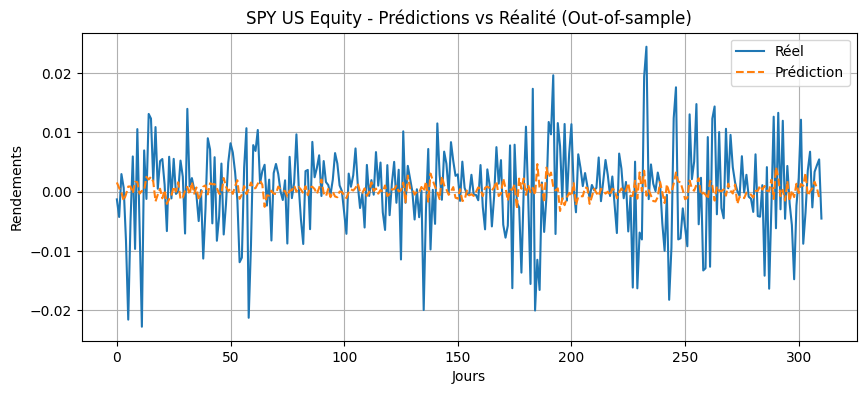


📊 Résultats pour : DIA US Equity
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


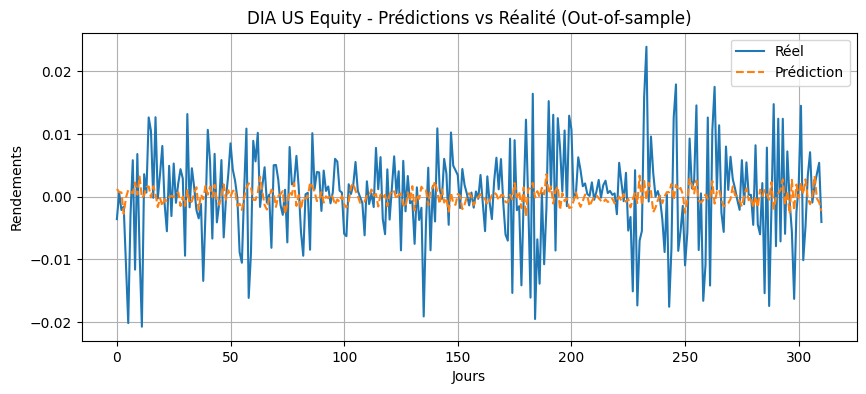


📊 Résultats pour : QQQ US Equity
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


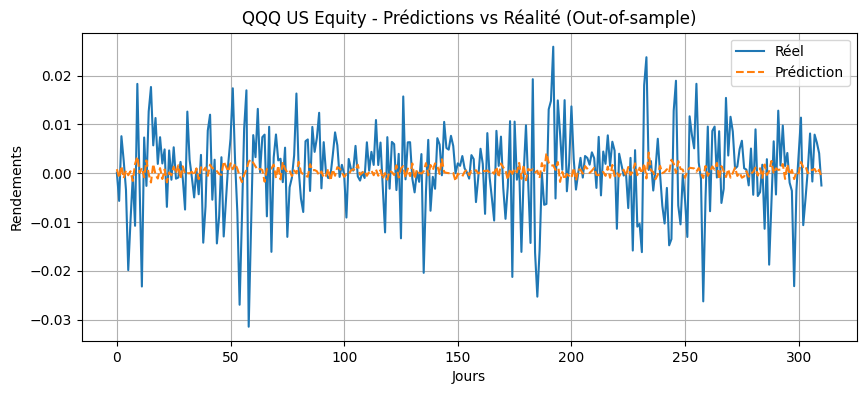

,MAE,MAPE (%),RMSE,THEIL-U
ETF,,,,
SPY,0.005665,140.062975,0.007445,0.863596
DIA,0.005495,128.893202,0.007322,0.858600
QQQ,0.006716,127.008961,0.008830,0.889777


In [13]:
summary = []

for asset in assets:
    print(f"\n📊 Résultats pour : {asset}")

    model = results[asset]['model']
    scaler = results[asset]['scaler']
    X_out = results[asset]['X_out']
    y_out = results[asset]['y_out']

    y_pred_scaled = model.predict(X_out)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_out.reshape(-1, 1))

    # Visualisation
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='Réel', linewidth=1.5)
    plt.plot(y_pred, label='Prédiction', linestyle='--')
    plt.title(f"{asset} - Prédictions vs Réalité (Out-of-sample)")
    plt.xlabel("Jours")
    plt.ylabel("Rendements")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Statistiques
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    theilu = theil_u(y_true, y_pred)

    summary.append({
        "ETF": asset.replace(" US Equity", ""),
        "MAE": mae,
        "MAPE (%)": mape,
        "RMSE": rmse,
        "THEIL-U": theilu
    })

# Résumé dans un tableau
summary_df = pd.DataFrame(summary).set_index("ETF")
from IPython.display import display
display(summary_df)
